# Analysis of models

Perform the imports

In [10]:
import pickle
from typing import List, Tuple

import numpy as np
from rich import print
from rich.panel import Panel
from rich.traceback import install; install()
from rich.progress import track
from os.path import exists

from scipy.special import softmax
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from tqdm import tqdm

from console import console
from feature_extraction import miles_cw_extractor
from models import example_model, svm_model
from preprocessing import analysis, preprocess
from sklearn.metrics import classification_report, plot_confusion_matrix

ModuleNotFoundError: ignored

Specify the number of training samples to use for the SVM

> The max is 45615

In [ ]:
NUMBER_OF_TRAINING_SAMPLES = 5615

The function to load the data

In [ ]:
def get_data(type_:str = "train") -> Tuple[List[str], List[int]]:
    """Load data from the provided filesystem

    Args:
        type_ (str, optional): Type of data to loads. Defaults to "train".

    Returns:
        Tuple[List[str], List[int]]: Tuple of x and y data.
    """

    x = []
    y = []
    with open(f"data/{type_}_text.txt", "r") as fp:
        x = fp.readlines()
    with open(f"data/{type_}_labels.txt", "r") as fp:
        y = [int(i) for i in fp.readlines()]
    return x, y


Patch together the functions required to train the SVM

In [ ]:
def svm_implementation() -> Tuple[SVC, TfidfTransformer, CountVectorizer]:
    """Implementation of an SVM classifier

    Returns:
        Tuple[SVC, TfidfTransformer, CountVectorizer]: The SVM model as well as
        the objects required to transform the data for the model.
    """
    
    console.log("Getting Data")
    train_x, train_y = get_data()
    # console.log(len(train_x))
    # console.log(train_x[:5])
    # console.log(train_y[:5])
    train_x = train_x[:NUMBER_OF_TRAINING_SAMPLES]
    train_y = train_y[:NUMBER_OF_TRAINING_SAMPLES]
    with console.status("Pre-processing Data...", spinner="aesthetic"):
        train_x_processed, tfid, vectorizer, get_best = miles_cw_extractor(train_x, train_y)
    with console.status("Generating Model...", spinner="aesthetic"):
        model = svm_model(train_x_processed, train_y)
    return model, tfid, vectorizer, get_best


NameError: ignored

Either load a pre-trained SVM from disk or train a new one

In [ ]:
if exists("checkpoint.p"):
    console.log("Checkpoint found in FS")
    with console.status("Loading checkpoint from file...", spinner="aesthetic"):
        svm_model, tfid, vectorizer, get_best= pickle.load(open("checkpoint.p", "rb"))
else:
    svm_model, tfid, vectorizer, get_best = svm_implementation()
    with console.status("Saving checkpoint to file...", spinner="aesthetic"):
        pickle.dump((svm_model, tfid, vectorizer, get_best), open("checkpoint.p", "wb" ))

[13:52:40] Checkpoint found in FS                            <ipython-input-5-f9973be1354e>:2

Load the pretrained model

In [ ]:
with console.status("Loading example model...", spinner="aesthetic"): 
        model, tokenizer, labels = example_model()

▰▰▰▱▱▱▱ Loading example model...

                                               tweet label  tweet_length
0  QT user In the original draft of the 7th book ...     2           114
1  Ben Smith  Smith concussion remains out of the...     1            77
2  Sorry bout the stream last night I crashed out...     1           123
3  Chase Headleys RBI double in the 8th inning of...     1           139
4  user Alciato Bee will invest 150 million in Ja...     2           111


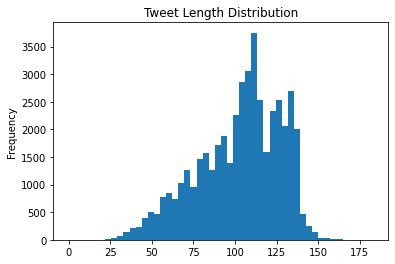

In [ ]:
analysis()


Get the validation data from disk

In [ ]:
v_x, v_y = get_data("val")

Predict the $Y$ values using the SVM

In [ ]:
Y_text_predictions_SVM = svm_model.predict(get_best.transform(
    tfid.transform(
        vectorizer.transform(v_x)
        ).toarray()
    )
)

And produce a report

In [ ]:
print(classification_report(v_y, Y_text_predictions_SVM))


'              precision    recall  f1-score   support\n\n           0       0.40      0.35      0.37       312\n           1       0.57      0.77      0.65       869\n           2       0.72      0.49      0.58       819\n\n    accuracy                           0.59      2000\n   macro avg       0.56      0.53      0.54      2000\nweighted avg       0.60      0.59      0.58      2000\n'

Do the same for the provided model

In [ ]:
Y_text_predictions = []


In [ ]:
for tweet in tqdm(v_x):
    encoded_input = tokenizer(tweet, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    prediction = ranking[0]
    Y_text_predictions.append(prediction)

NameError: ignored

In [ ]:
print(classification_report(v_y, Y_text_predictions))

NameError: ignored

In [ ]:
#confusion matrix of best model results 
titles_options = [("Confusion matrix without normalization", None),
                  ("Normalized confusion matrix", 'true')]
labels = ['Negative','Neutral','Positive']
for title, normalize in titles_options:
  disp = plot_confusion_matrix(svm_model, Y_text_predictions, v_y, display_labels=labels, cmap = plt.cm.Blues, normalize= normalize)
  disp.ax_.set_title(title)
  plt.xticks(rotation=90)

plt.show()

NameError: ignored